In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DDPG_single_lane import DDPGagent_single_lane
import traci
import traci.constants as tc
import math
import torch
import torch.autograd
import torch.optim as optim
import torch.nn as nn
from collections import deque
import random
from model_single_lane import *
from utils_single_lane import *
from memory import *

In [2]:
import os, sys
tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
sys.path.append(tools)

In [3]:
import pickle
filename = 'finalized_230_mode0_02_750_new_new_05.sav'
loaded_model_notrigger = pickle.load(open(filename, 'rb'))

In [14]:
#test the model
r=36.61
rl1='autonomous_vehicle'
num_veh=21
state_total=np.zeros((1,3))
action_total=np.zeros(1)
speed_total=np.zeros(21)
pos_total=np.zeros(21)

for episode in range(1):

    traci.start(["sumo-gui", "-c", "/Users/yuewang/document/maps1/ring_example_20190424-2048001556153280.685167.sumo.cfg"])
    traci.simulationStep()
    vehID=traci.vehicle.getIDList()
    while len(vehID)!=num_veh:
        traci.close()
        traci.start(["sumo-gui", "-c", "/Users/yuewang/document/maps1/ring_example_20190424-2048001556153280.685167.sumo.cfg"])
        traci.simulationStep()
        vehID=traci.vehicle.getIDList()
        
        
    for j in range(len(vehID)):
        testVname=vehID[j]
            
        vehposition=traci.vehicle.getPosition(testVname)
        vehpos_1=vehposition[0]-r
        vehpos_2=vehposition[1]-r
        
        if vehpos_1-1>0 and vehpos_2<0:
                traci.vehicle.setRouteID(testVname, 'routebottom')
    
        if vehpos_1>0 and vehpos_2-1>0:
                traci.vehicle.setRouteID(testVname, 'routeright')
    
        if vehpos_1+1<0 and vehpos_2>0:
                traci.vehicle.setRouteID(testVname, 'routetop')
    
        if vehpos_1<0 and vehpos_2+1<0:
                traci.vehicle.setRouteID(testVname, 'routeleft')
        
        
# reset state
    for reset_state in range(1000):
        traci.simulationStep()
        speed_total_e=np.zeros(21)
        pos_total_e=np.zeros(21)
        for j in range(len(vehID)):
            testVname=vehID[j]
            
            traci.vehicle.subscribe(testVname,(tc.VAR_SPEED,tc.VAR_POSITION,tc.VAR_LANEPOSITION))
            
            vehicle_obs=traci.vehicle.getSubscriptionResults(testVname)
            speed_total_e[j]=vehicle_obs[tc.VAR_SPEED]
            
            vehposition=traci.vehicle.getPosition(testVname)
            vehpos_1=vehposition[0]-r
            vehpos_2=vehposition[1]-r
        
            if vehpos_1>0 and vehpos_2<0:
                traci.vehicle.setRouteID(testVname, 'routebottom')
                dist_pos_e=traci.vehicle.getLanePosition(testVname)
                dist_pos=dist_pos_e
    
            if vehpos_1>0 and vehpos_2>0:
                traci.vehicle.setRouteID(testVname, 'routeright')
                dist_pos_e=traci.vehicle.getLanePosition(testVname)
                dist_pos=dist_pos_e+230/4
    
            if vehpos_1<0 and vehpos_2>0:
                traci.vehicle.setRouteID(testVname, 'routetop')
                dist_pos_e=traci.vehicle.getLanePosition(testVname)
                dist_pos=dist_pos_e+230/4*2
    
            if vehpos_1<0 and vehpos_2<0:
                traci.vehicle.setRouteID(testVname, 'routeleft')
                dist_pos_e=traci.vehicle.getLanePosition(testVname)
                dist_pos=dist_pos_e+230/4*3

            traci.vehicle.subscribe(testVname,(tc.VAR_SPEED,tc.VAR_POSITION))
            pos_total_e[j]=dist_pos
            
        speed_total=np.vstack((speed_total,speed_total_e))
        pos_total=np.vstack((pos_total,pos_total_e))
        
    vehicle_obs_rl1=traci.vehicle.getSubscriptionResults(vehID[0])
    speed_rl1=vehicle_obs_rl1[tc.VAR_SPEED]
    headway_total=traci.vehicle.getLeader(rl1,200)
    veh_leader=headway_total[0]
    headway=headway_total[1]+2
    speed_leader=traci.vehicle.getSpeed(veh_leader)

    state=np.array([speed_rl1,speed_leader,headway])
    
#start training
    traci.vehicle.setSpeedMode("autonomous_vehicle",0)
    for step in range(3000):
   
        state_01 = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action=loaded_model_notrigger(state_01)
        action=action.detach().numpy()[0]
        print(step, state_01, action)

 # accelerating
        acc=action
        Speed_e=acc*0.1+state[0]
        Speed=max(Speed_e,0)
        traci.vehicle.slowDown(rl1,Speed,0.1)

# done
        traci.simulationStep()
        speed_total_e=np.zeros(21)
        pos_total_e=np.zeros(21)
        for j in range(len(vehID)):
            testVname=vehID[j]
 
            traci.vehicle.subscribe(testVname,(tc.VAR_SPEED,tc.VAR_POSITION,tc.VAR_LANEPOSITION))
            
            vehicle_obs=traci.vehicle.getSubscriptionResults(testVname)
            speed_total_e[j]=vehicle_obs[tc.VAR_SPEED]
            
            vehposition=traci.vehicle.getPosition(testVname)
            vehpos_1=vehposition[0]-r
            vehpos_2=vehposition[1]-r
            if vehpos_1>0 and vehpos_2<0:
                traci.vehicle.setRouteID(testVname, 'routebottom')
                dist_pos_e=traci.vehicle.getLanePosition(testVname)
                dist_pos=dist_pos_e
                
            if vehpos_1>0 and vehpos_2>0:
                traci.vehicle.setRouteID(testVname, 'routeright')
                dist_pos_e=traci.vehicle.getLanePosition(testVname)
                dist_pos=dist_pos_e+230/4
    
            if vehpos_1<0 and vehpos_2>0:
                traci.vehicle.setRouteID(testVname, 'routetop')
                dist_pos_e=traci.vehicle.getLanePosition(testVname)
                dist_pos=dist_pos_e+230/4*2
    
            if vehpos_1<0 and vehpos_2<0:
                traci.vehicle.setRouteID(testVname, 'routeleft')
                dist_pos_e=traci.vehicle.getLanePosition(testVname)
                dist_pos=dist_pos_e+230/4*3
            
            traci.vehicle.subscribe(testVname,(tc.VAR_SPEED,tc.VAR_POSITION))
            pos_total_e[j]=dist_pos
            
        speed_total=np.vstack((speed_total,speed_total_e))
        pos_total=np.vstack((pos_total,pos_total_e))
        vehID=traci.vehicle.getIDList()

        
# new_state and reward
        done=0
        if done==0 or step==2999:
            vehicle_obs_rl1=traci.vehicle.getSubscriptionResults(rl1)
            
            speed_rl1=vehicle_obs_rl1[tc.VAR_SPEED]
            headway_total=traci.vehicle.getLeader(rl1,200)
            veh_leader=headway_total[0]
            headway=headway_total[1]+2
            speed_leader=traci.vehicle.getSpeed(veh_leader)

            new_state=np.array([speed_rl1,speed_leader,headway])
        
        state = new_state

    traci.close()



 Retrying in 1 seconds
0 tensor([[4.6659, 2.8820, 6.4310]]) [-2.7705073]
1 tensor([[4.5273, 2.7347, 6.2517]]) [-2.7274518]
2 tensor([[4.3910, 2.5889, 6.0715]]) [-2.6775417]
3 tensor([[4.2571, 2.4454, 5.8903]]) [-2.6219609]
4 tensor([[4.1260, 2.3046, 5.7082]]) [-2.5631921]
5 tensor([[3.9978, 2.1668, 5.5251]]) [-2.5034304]
6 tensor([[3.8727, 2.0324, 5.3411]]) [-2.4402976]
7 tensor([[3.7507, 1.9015, 5.1561]]) [-2.3650684]
8 tensor([[3.6324, 1.7743, 4.9703]]) [-2.2693148]
9 tensor([[3.5189, 1.6509, 4.7835]]) [-2.1567817]
10 tensor([[3.4111, 1.4979, 4.5922]]) [-2.0503702]
11 tensor([[3.3086, 1.3573, 4.3971]]) [-2.0868459]
12 tensor([[3.2042, 1.2273, 4.1994]]) [-2.347589]
13 tensor([[3.0869, 1.1067, 4.0014]]) [-2.684193]
14 tensor([[2.9526, 0.9945, 3.8056]]) [-2.8823185]
15 tensor([[2.8085, 0.8901, 3.6137]]) [-2.9578555]
16 tensor([[2.6606, 0.7928, 3.4269]]) [-2.9827912]
17 tensor([[2.5115, 0.7021, 3.2460]]) [-2.9909601]
18 tensor([[2.3619, 0.6178, 3.0716]]) [-2.993491]
19 tensor([[2.2123, 0

160 tensor([[3.2206, 4.0181, 6.6083]]) [0.8473801]
161 tensor([[3.2630, 4.0817, 6.6902]]) [0.8588271]
162 tensor([[3.3059, 4.1455, 6.7741]]) [0.8784059]
163 tensor([[3.3498, 4.2095, 6.8601]]) [0.90407765]
164 tensor([[3.3950, 4.2736, 6.9480]]) [0.93314934]
165 tensor([[3.4417, 4.3379, 7.0376]]) [0.9628297]
166 tensor([[3.4898, 4.4023, 7.1288]]) [0.99074024]
167 tensor([[3.5394, 4.4669, 7.2216]]) [1.0152338]
168 tensor([[3.5901, 4.5316, 7.3157]]) [1.0354687]
169 tensor([[3.6419, 4.5964, 7.4112]]) [1.0512633]
170 tensor([[3.6945, 4.6613, 7.5079]]) [1.0628769]
171 tensor([[3.7476, 4.7263, 7.6057]]) [1.0708046]
172 tensor([[3.8011, 4.7914, 7.7048]]) [1.0756037]
173 tensor([[3.8549, 4.8566, 7.8049]]) [1.07779]
174 tensor([[3.9088, 4.9219, 7.9062]]) [1.0777693]
175 tensor([[3.9627, 4.9873, 8.0087]]) [1.0758466]
176 tensor([[4.0165, 5.0527, 8.1123]]) [1.0722231]
177 tensor([[4.0701, 5.1181, 8.2171]]) [1.0669628]
178 tensor([[4.1234, 5.1837, 8.3231]]) [1.0600822]
179 tensor([[4.1765, 5.2492, 8

316 tensor([[ 2.1058,  0.0000, 13.4692]]) [-0.85336936]
317 tensor([[ 2.0631,  0.0000, 13.2629]]) [-0.8211231]
318 tensor([[ 2.0221,  0.0000, 13.0607]]) [-0.7902173]
319 tensor([[ 1.9825,  0.0000, 12.8624]]) [-0.7606428]
320 tensor([[ 1.9445,  0.0000, 12.6680]]) [-0.73236585]
321 tensor([[ 1.9079,  0.0000, 12.4772]]) [-0.70533144]
322 tensor([[ 1.8726,  0.0000, 12.2899]]) [-0.6794671]
323 tensor([[ 1.8387,  0.0000, 12.1061]]) [-0.65468866]
324 tensor([[ 1.8059,  0.0000, 11.9255]]) [-0.630907]
325 tensor([[ 1.7744,  0.0000, 11.7480]]) [-0.60802555]
326 tensor([[ 1.7440,  0.0000, 11.5736]]) [-0.5859582]
327 tensor([[ 1.7147,  0.0000, 11.4022]]) [-0.564625]
328 tensor([[ 1.6864,  0.0000, 11.2335]]) [-0.54395044]
329 tensor([[ 1.6592,  0.0000, 11.0676]]) [-0.5238763]
330 tensor([[1.6331e+00, 2.7223e-05, 1.0904e+01]]) [-0.5043204]
331 tensor([[1.6078e+00, 2.9449e-04, 1.0744e+01]]) [-0.48497242]
332 tensor([[1.5836e+00, 8.2414e-04, 1.0585e+01]]) [-0.46587223]
333 tensor([[1.5603e+00, 1.6389e

480 tensor([[5.3533, 6.5697, 9.5528]]) [0.84157217]
481 tensor([[5.3954, 6.6315, 9.6764]]) [0.8045243]
482 tensor([[5.4356, 6.6924, 9.8020]]) [0.76533246]
483 tensor([[5.4739, 6.7524, 9.9299]]) [0.72404176]
484 tensor([[ 5.5101,  6.8113, 10.0600]]) [0.68068576]
485 tensor([[ 5.5441,  6.8691, 10.1925]]) [0.63534653]
486 tensor([[ 5.5759,  6.9256, 10.3275]]) [0.58811414]
487 tensor([[ 5.6053,  6.9807, 10.4651]]) [0.5390463]
488 tensor([[ 5.6322,  7.0343, 10.6053]]) [0.48813927]
489 tensor([[ 5.6566,  7.0862, 10.7482]]) [0.435342]
490 tensor([[ 5.6784,  7.1362, 10.8940]]) [0.3804779]
491 tensor([[ 5.6974,  7.1842, 11.0427]]) [0.32333875]
492 tensor([[ 5.7136,  7.2299, 11.1943]]) [0.26351598]
493 tensor([[ 5.7268,  7.2732, 11.3489]]) [0.20061004]
494 tensor([[ 5.7368,  7.3139, 11.5067]]) [0.13403963]
495 tensor([[ 5.7435,  7.3516, 11.6675]]) [0.06336373]
496 tensor([[ 5.7467,  7.3863, 11.8314]]) [-0.01181608]
497 tensor([[ 5.7461,  7.4175, 11.9986]]) [-0.09150666]
498 tensor([[ 5.7415,  7.

631 tensor([[1.4863, 1.0054, 7.4483]]) [0.48105073]
632 tensor([[1.5104, 1.0417, 7.4015]]) [0.5318564]
633 tensor([[1.5370, 1.0784, 7.3556]]) [0.58352137]
634 tensor([[1.5661, 1.1155, 7.3106]]) [0.64426035]
635 tensor([[1.5983, 1.1529, 7.2660]]) [0.7144209]
636 tensor([[1.6341, 1.1907, 7.2217]]) [0.7834313]
637 tensor([[1.6732, 1.2288, 7.1772]]) [0.8365406]
638 tensor([[1.7151, 1.2672, 7.1325]]) [0.86548996]
639 tensor([[1.7583, 1.3060, 7.0872]]) [0.872666]
640 tensor([[1.8020, 1.3450, 7.0415]]) [0.8676233]
641 tensor([[1.8454, 1.3844, 6.9954]]) [0.86115086]
642 tensor([[1.8884, 1.4240, 6.9490]]) [0.8609631]
643 tensor([[1.9315, 1.4639, 6.9022]]) [0.8705232]
644 tensor([[1.9750, 1.5041, 6.8551]]) [0.88988054]
645 tensor([[2.0195, 1.5445, 6.8076]]) [0.91679144]
646 tensor([[2.0653, 1.5852, 6.7596]]) [0.94752127]
647 tensor([[2.1127, 1.6261, 6.7110]]) [0.9775522]
648 tensor([[2.1616, 1.6673, 6.6615]]) [1.0023618]
649 tensor([[2.2117, 1.7087, 6.6112]]) [1.018203]
650 tensor([[2.2626, 1.75

792 tensor([[ 2.9433,  4.8219, 17.1972]]) [-0.5398676]
793 tensor([[ 2.9163,  4.7161, 17.3772]]) [-0.3973599]
794 tensor([[ 2.8964,  4.6094, 17.5485]]) [-0.2640294]
795 tensor([[ 2.8832,  4.5022, 17.7104]]) [-0.15318523]
796 tensor([[ 2.8755,  4.3946, 17.8623]]) [-0.07868057]
797 tensor([[ 2.8716,  4.2867, 18.0038]]) [-0.04664873]
798 tensor([[ 2.8693,  4.1788, 18.1347]]) [-0.04898327]
799 tensor([[ 2.8668,  4.0710, 18.2552]]) [-0.06831919]
800 tensor([[ 2.8634,  3.9635, 18.3652]]) [-0.09361349]
801 tensor([[ 2.8587,  3.8563, 18.4649]]) [-0.11740853]
802 tensor([[ 2.8529,  3.7497, 18.5546]]) [-0.1217336]
803 tensor([[ 2.8468,  3.6438, 18.6343]]) [-0.09429089]
804 tensor([[ 2.8421,  3.5386, 18.7040]]) [-0.04169862]
805 tensor([[ 2.8400,  3.4344, 18.7634]]) [0.02824701]
806 tensor([[ 2.8414,  3.3311, 18.8124]]) [0.11643275]
807 tensor([[ 2.8472,  3.2290, 18.8506]]) [0.22243501]
808 tensor([[ 2.8583,  3.1281, 18.8775]]) [0.33795303]
809 tensor([[ 2.8752,  3.0285, 18.8929]]) [0.44875658]
8

957 tensor([[3.6959, 4.5497, 5.2613]]) [0.8264952]
958 tensor([[3.7372, 4.6034, 5.3479]]) [0.94532406]
959 tensor([[3.7845, 4.6571, 5.4352]]) [0.99728125]
960 tensor([[3.8343, 4.7108, 5.5228]]) [1.0176537]
961 tensor([[3.8852, 4.7644, 5.6108]]) [1.0243368]
962 tensor([[3.9364, 4.8180, 5.6989]]) [1.0248754]
963 tensor([[3.9877, 4.8714, 5.7873]]) [1.0223174]
964 tensor([[4.0388, 4.9248, 5.8759]]) [1.0178671]
965 tensor([[4.0897, 4.9780, 5.9647]]) [1.0120703]
966 tensor([[4.1403, 5.0311, 6.0538]]) [1.0051913]
967 tensor([[4.1906, 5.0840, 6.1432]]) [0.9973922]
968 tensor([[4.2404, 5.1368, 6.2328]]) [0.98879373]
969 tensor([[4.2899, 5.1893, 6.3227]]) [0.9794563]
970 tensor([[4.3388, 5.2415, 6.4130]]) [0.96944916]
971 tensor([[4.3873, 5.2935, 6.5036]]) [0.9588048]
972 tensor([[4.4352, 5.3452, 6.5946]]) [0.9475235]
973 tensor([[4.4826, 5.3966, 6.6860]]) [0.9356164]
974 tensor([[4.5294, 5.4476, 6.7778]]) [0.923048]
975 tensor([[4.5756, 5.4982, 6.8701]]) [0.909784]
976 tensor([[4.6210, 5.5483, 

1108 tensor([[ 3.4496,  1.7153, 10.9960]]) [-0.24675855]
1109 tensor([[ 3.4373,  1.7206, 10.8244]]) [-0.22989324]
1110 tensor([[ 3.4258,  1.7268, 10.6545]]) [-0.21884942]
1111 tensor([[ 3.4149,  1.7337, 10.4863]]) [-0.21537492]
1112 tensor([[ 3.4041,  1.7414, 10.3201]]) [-0.21999054]
1113 tensor([[ 3.3931,  1.7499, 10.1558]]) [-0.23172837]
1114 tensor([[3.3815, 1.7591, 9.9935]]) [-0.24821502]
1115 tensor([[3.3691, 1.7690, 9.8335]]) [-0.26621804]
1116 tensor([[3.3558, 1.7795, 9.6759]]) [-0.28249353]
1117 tensor([[3.3417, 1.7907, 9.5208]]) [-0.29457173]
1118 tensor([[3.3269, 1.8025, 9.3683]]) [-0.3011313]
1119 tensor([[3.3119, 1.8149, 9.2186]]) [-0.3019011]
1120 tensor([[3.2968, 1.8278, 9.0717]]) [-0.29732716]
1121 tensor([[3.2819, 1.8413, 8.9277]]) [-0.28819054]
1122 tensor([[3.2675, 1.8554, 8.7865]]) [-0.2753675]
1123 tensor([[3.2537, 1.8700, 8.6481]]) [-0.25970653]
1124 tensor([[3.2408, 1.8850, 8.5125]]) [-0.24198836]
1125 tensor([[3.2287, 1.9005, 8.3797]]) [-0.22295263]
1126 tensor([

1272 tensor([[4.3288, 5.1870, 9.7562]]) [-0.39784598]
1273 tensor([[4.3089, 5.1422, 9.8395]]) [-0.33760986]
1274 tensor([[4.2920, 5.0955, 9.9199]]) [-0.26722905]
1275 tensor([[4.2787, 5.0472, 9.9967]]) [-0.18912303]
1276 tensor([[ 4.2692,  4.9973, 10.0695]]) [-0.10623052]
1277 tensor([[ 4.2639,  4.9459, 10.1377]]) [-0.02181691]
1278 tensor([[ 4.2628,  4.8932, 10.2008]]) [0.06045915]
1279 tensor([[ 4.2658,  4.8393, 10.2581]]) [0.13636681]
1280 tensor([[ 4.2727,  4.7843, 10.3093]]) [0.20118922]
1281 tensor([[ 4.2827,  4.7284, 10.3539]]) [0.25036466]
1282 tensor([[ 4.2952,  4.6717, 10.3915]]) [0.28046885]
1283 tensor([[ 4.3093,  4.6143, 10.4220]]) [0.29014874]
1284 tensor([[ 4.3238,  4.5563, 10.4452]]) [0.2804872]
1285 tensor([[ 4.3378,  4.4978, 10.4613]]) [0.25466487]
1286 tensor([[ 4.3505,  4.4391, 10.4701]]) [0.2170237]
1287 tensor([[ 4.3614,  4.3802, 10.4720]]) [0.17202836]
1288 tensor([[ 4.3700,  4.3211, 10.4671]]) [0.12348656]
1289 tensor([[ 4.3761,  4.2621, 10.4557]]) [0.07424437]


1433 tensor([[3.8542, 3.9621, 4.1749]]) [0.15935732]
1434 tensor([[3.8621, 3.9692, 4.1856]]) [0.16214523]
1435 tensor([[3.8702, 3.9763, 4.1962]]) [0.16462873]
1436 tensor([[3.8785, 3.9835, 4.2067]]) [0.1668118]
1437 tensor([[3.8868, 3.9907, 4.2171]]) [0.1686988]
1438 tensor([[3.8952, 3.9980, 4.2274]]) [0.17029372]
1439 tensor([[3.9038, 4.0054, 4.2375]]) [0.17160873]
1440 tensor([[3.9123, 4.0129, 4.2476]]) [0.1726492]
1441 tensor([[3.9210, 4.0206, 4.2576]]) [0.17342731]
1442 tensor([[3.9296, 4.0284, 4.2674]]) [0.1739525]
1443 tensor([[3.9383, 4.0363, 4.2772]]) [0.17423712]
1444 tensor([[3.9471, 4.0444, 4.2870]]) [0.17429182]
1445 tensor([[3.9558, 4.0526, 4.2966]]) [0.17412947]
1446 tensor([[3.9645, 4.0611, 4.3063]]) [0.17376448]
1447 tensor([[3.9732, 4.0697, 4.3160]]) [0.1732065]
1448 tensor([[3.9818, 4.0786, 4.3256]]) [0.17246991]
1449 tensor([[3.9904, 4.0877, 4.3354]]) [0.17156273]
1450 tensor([[3.9990, 4.0970, 4.3452]]) [0.17049709]
1451 tensor([[4.0075, 4.1065, 4.3551]]) [0.16928202

1595 tensor([[3.6269, 3.0011, 6.8327]]) [-0.30186987]
1596 tensor([[3.6118, 2.9906, 6.7706]]) [-0.29341573]
1597 tensor([[3.5971, 2.9810, 6.7090]]) [-0.28461534]
1598 tensor([[3.5829, 2.9723, 6.6479]]) [-0.2754654]
1599 tensor([[3.5691, 2.9645, 6.5875]]) [-0.26595718]
1600 tensor([[3.5558, 2.9575, 6.5276]]) [-0.25607592]
1601 tensor([[3.5430, 2.9514, 6.4685]]) [-0.24579155]
1602 tensor([[3.5307, 2.9461, 6.4100]]) [-0.23507276]
1603 tensor([[3.5190, 2.9416, 6.3523]]) [-0.2238886]
1604 tensor([[3.5078, 2.9381, 6.2953]]) [-0.21221292]
1605 tensor([[3.4972, 2.9353, 6.2391]]) [-0.20002922]
1606 tensor([[3.4871, 2.9334, 6.1838]]) [-0.18732385]
1607 tensor([[3.4778, 2.9323, 6.1292]]) [-0.17411053]
1608 tensor([[3.4691, 2.9320, 6.0755]]) [-0.16041186]
1609 tensor([[3.4611, 2.9325, 6.0226]]) [-0.14626704]
1610 tensor([[3.4537, 2.9338, 5.9706]]) [-0.13172501]
1611 tensor([[3.4472, 2.9359, 5.9195]]) [-0.11684594]
1612 tensor([[3.4413, 2.9387, 5.8692]]) [-0.10168615]
1613 tensor([[3.4362, 2.9423, 

FatalTraCIError: connection closed by SUMO

In [12]:
import scipy.io as sio
import matplotlib.pyplot as plt
sio.savemat('CDC_2023_speed-clean.mat', {'speed_total_s': speed_total, 'pos_total_s':pos_total})


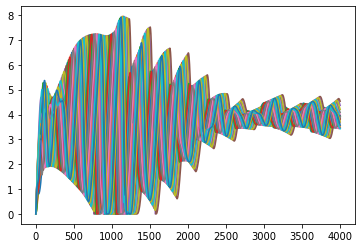

In [13]:
plt.plot(speed_total)
plt.show()